## Plot bathymetry and CTD profiles from Berufjordur

Angel sent these on March 4th, 2024.

In [13]:
import cmocean as cmo
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scipy.io as sio

In [3]:
filename = "../beru_2022.nc"
nc = Dataset(filename, "r")
#nc

In [5]:
elev = nc["elevation"][:]
lat = nc["latitude"][:]
lon = nc["longitude"][:]

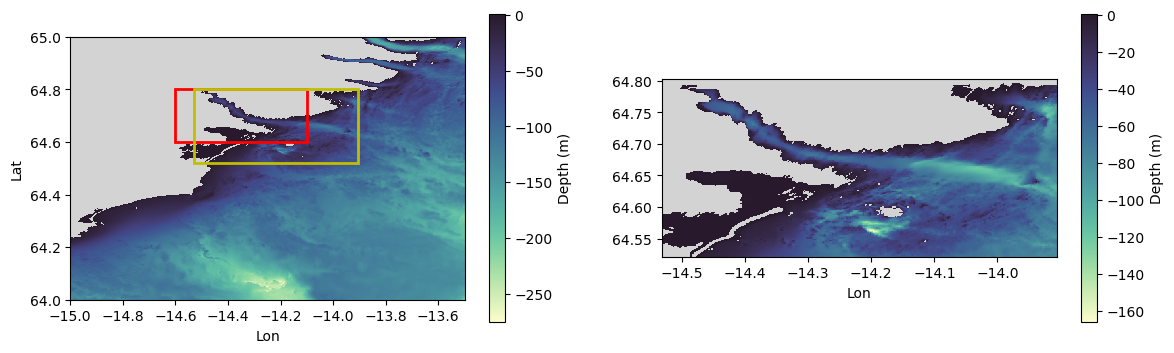

In [6]:
# Plot bathy data
fig, (ax,ax2) = plt.subplots(1,2, figsize=(14,4))
ax.set_facecolor("lightgray")
ax2.set_facecolor("lightgray")

## Plot all data
pc = ax.pcolormesh(lon,lat,elev, cmap=cmo.cm.deep)
plt.colorbar(pc, ax=ax, label= "Depth (m)")
# Draw region of interest
ax.add_patch(Rectangle((-14.6, 64.6), 0.5, 0.2, #((origin), w, h)
                       ec = "r", 
                       fill = False, 
                       lw = 2)) 

## Plot only region of interest
inix = 450
iniy = 500
dx = 600
dy = 270
endx = inix + dx
endy = iniy + dy
w_lon = lon[endx] - lon[inix]
h_lat = lat[endy] - lat[iniy]

pc2 = ax2.pcolormesh(lon[inix:endx],lat[iniy:endy],elev[iniy:endy, inix:endx], cmap=cmo.cm.deep)
plt.colorbar(pc2, ax=ax2, label= "Depth (m)")
# Draw region of interest in ax to check location
ax.add_patch(Rectangle((lon[inix], lat[iniy]), w_lon, h_lat, #((origin), w, h)
                       ec = "y", 
                       fill = False, 
                       lw = 2)) 
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax2.set_xlabel("Lon")
ax.set_aspect(1)
ax2.set_aspect(1)
plt.show()
print(f"The indices for the yellow box are: x1={inix}, x2={endx}, y1={iniy}, y2={endy}")

Red square: region of interest, yellow square: domain on the right panel.

### Profiles

.mat files contain a matlab structure *tt* which contains more matlab structures for each station. Within those structures you can find the following variables: temp, sal, oxy, osat, chla, depth, lat, lon, press, pden, bdepth, mday, hhmm.

In [8]:
def get_dframe(filename, stn):
    '''
    Make a pandas dataframe from a mat file of a particular file from Angel
    
    INPUT
       filename:: str, path to .mat file from Angel
       stn:: str, station id
    
    RETURNS
       df :: pandas dataframe with columns: 'temp', 'sal', 'oxy', 'osat', 'chla',
             'depth', 'pden', indexed by pressure '''
    
    mat = sio.loadmat(filename, squeeze_me=True)  # load mat-file
    tt = mat['tt']  
    mdtype = tt.dtype  
    ndata = {n: tt[stn].item()[n].item() for n in tt[stn].item().dtype.names}
    columns = ['temp', 'sal', 'oxy', 'osat', 'chla', 'depth', 'press', 'pden']
    df = pd.DataFrame(np.concatenate([np.expand_dims(ndata[c], axis=1) for c in columns], axis=1),
                  columns=columns)
    df = df.set_index('press')
    return df

In [14]:
# Get list of CTD file names
filedir = "../Archive/"
filenames = []
for file in os.listdir(filedir):
    if file.endswith(".mat"):
        filenames.append(file)

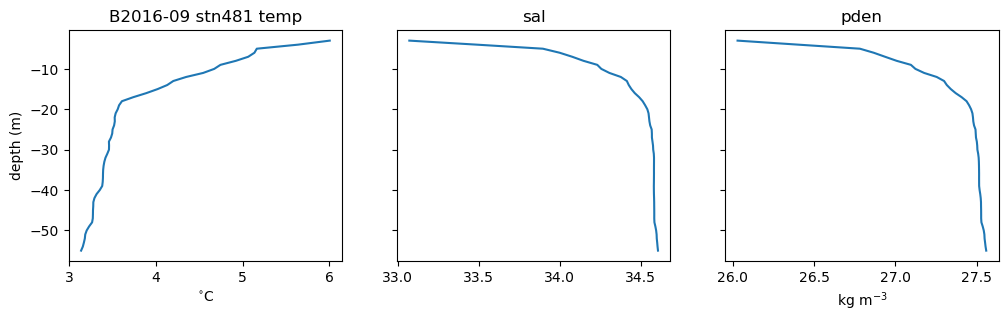

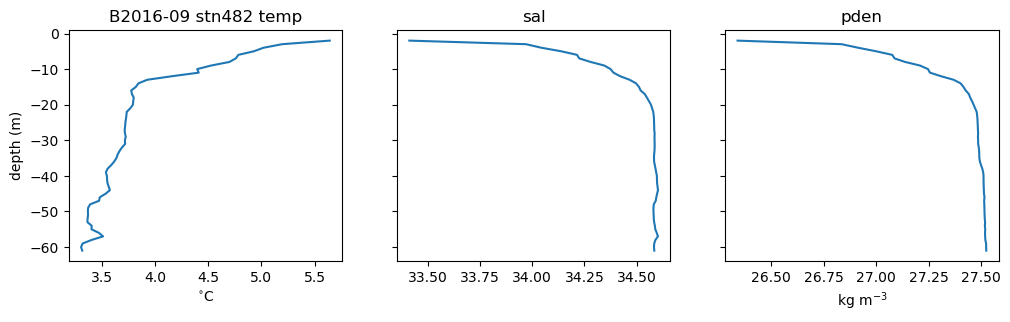

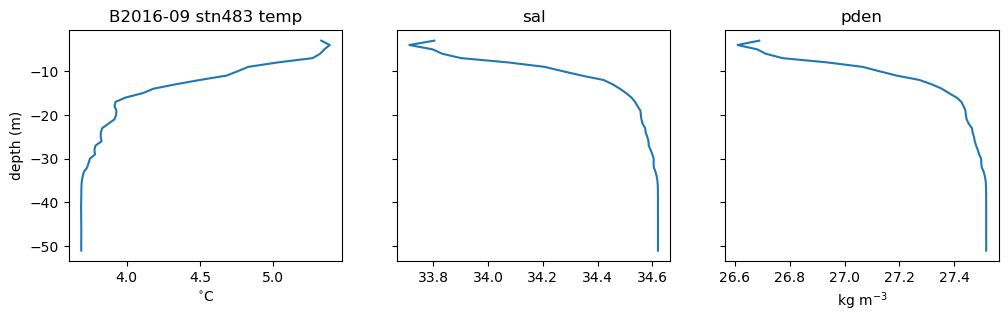

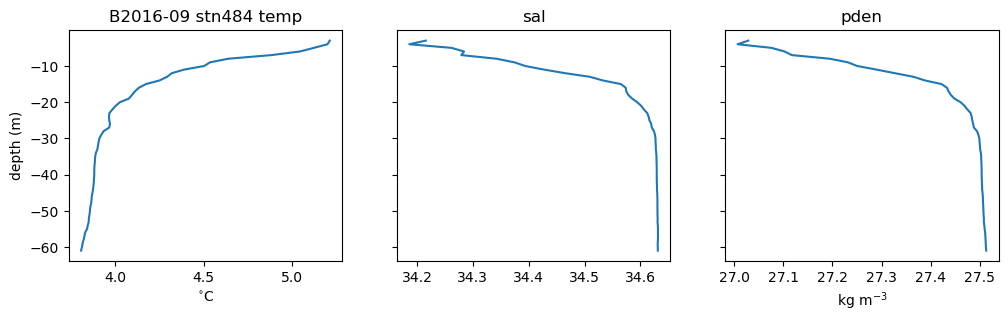

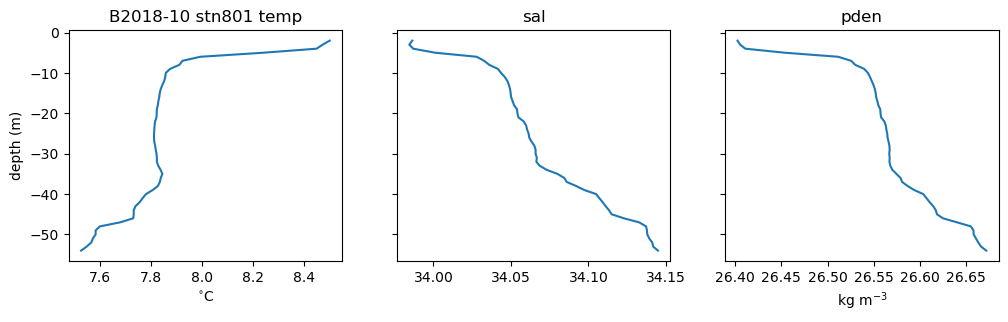

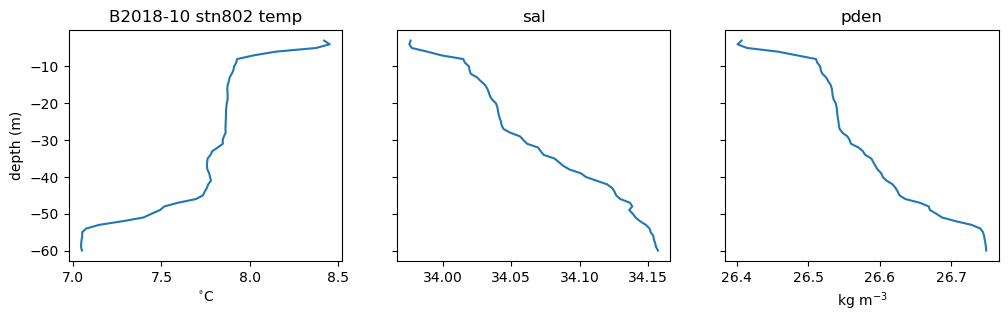

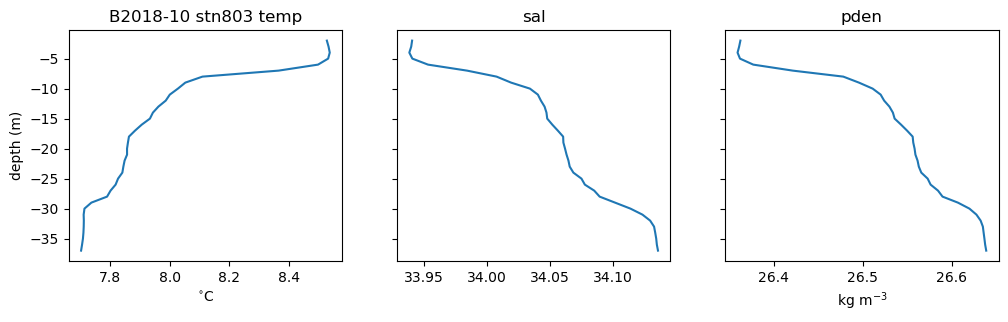

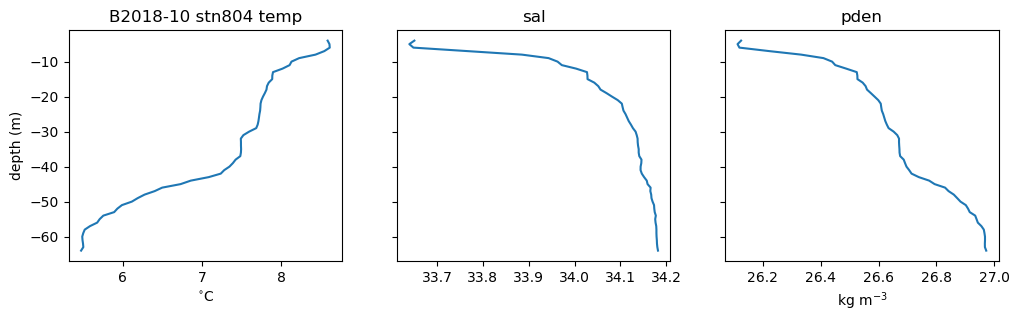

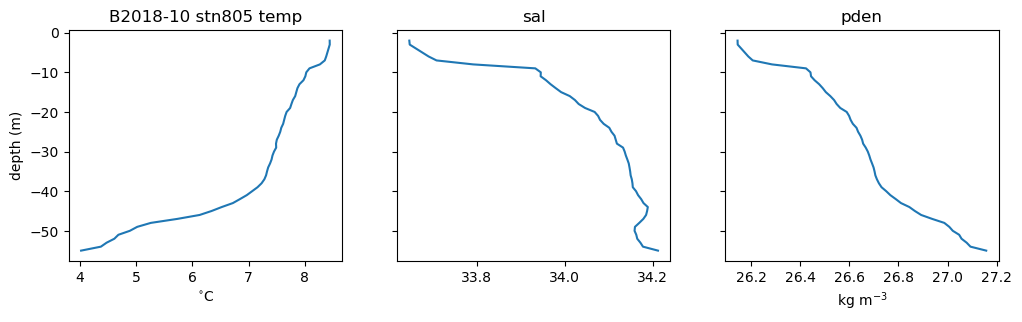

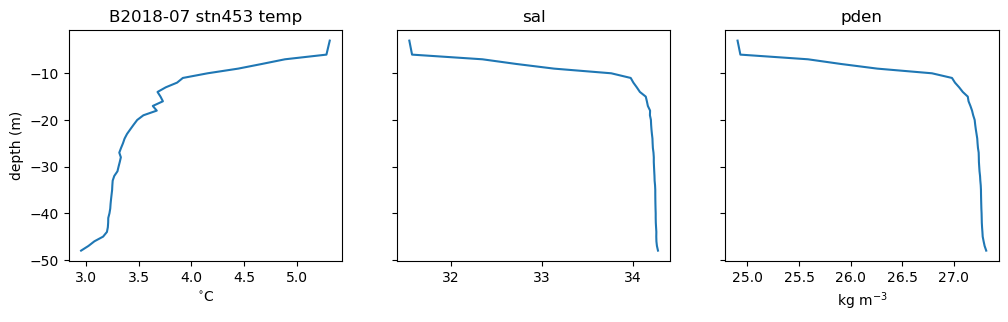

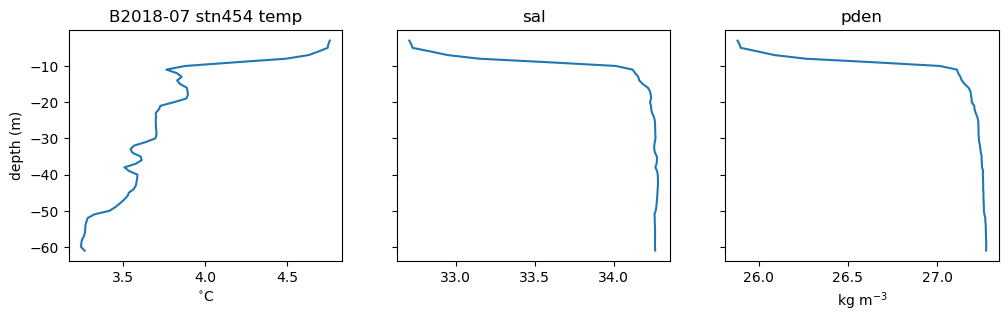

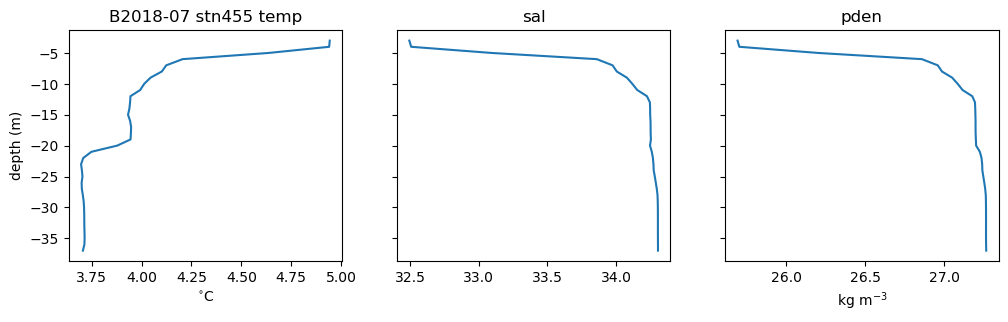

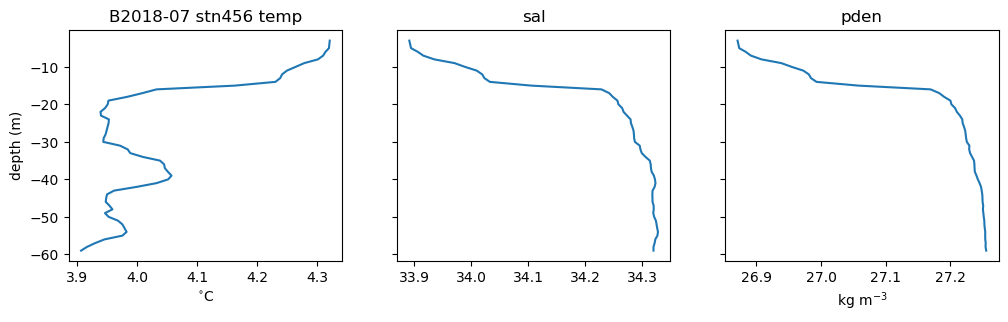

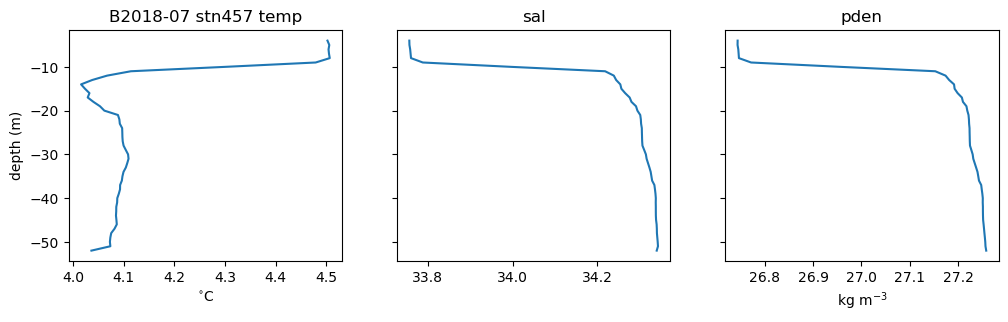

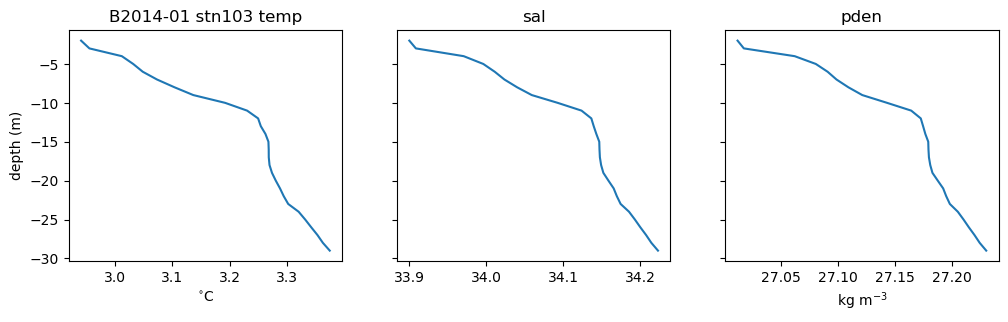

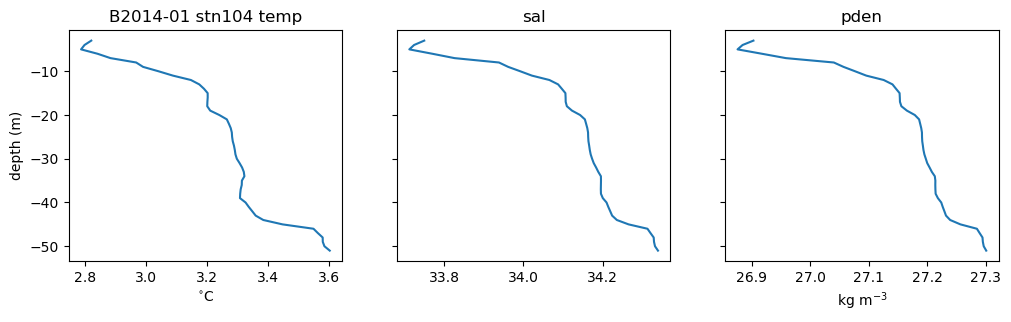

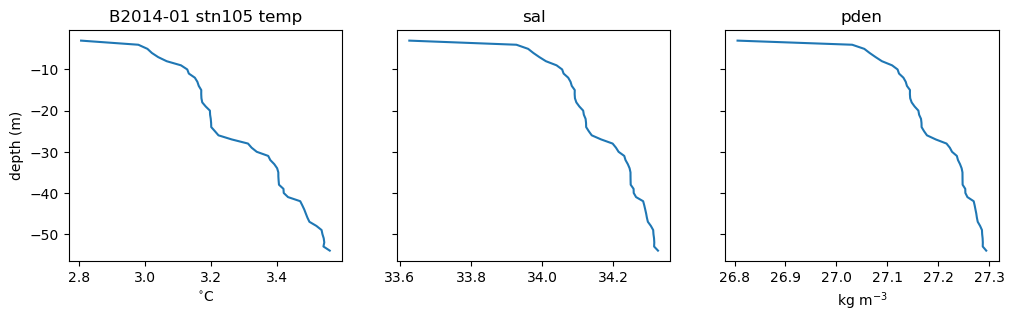

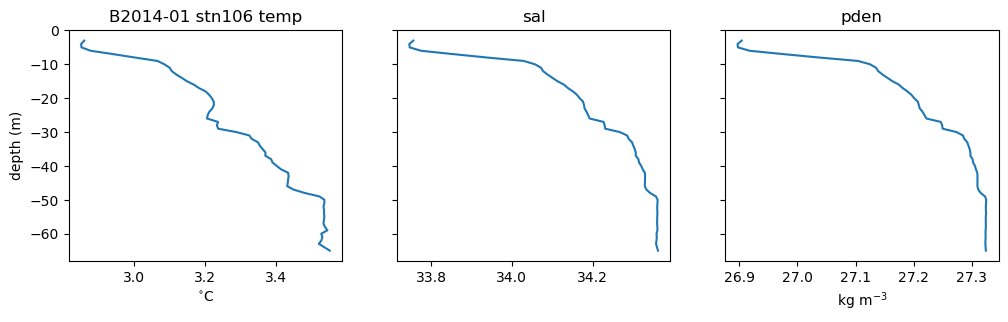

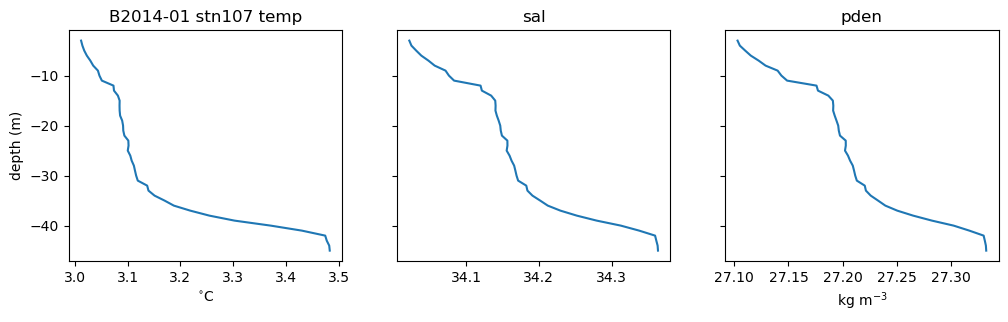

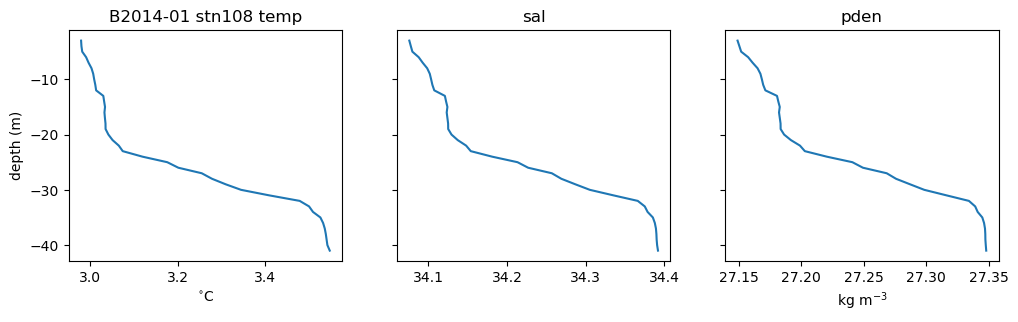

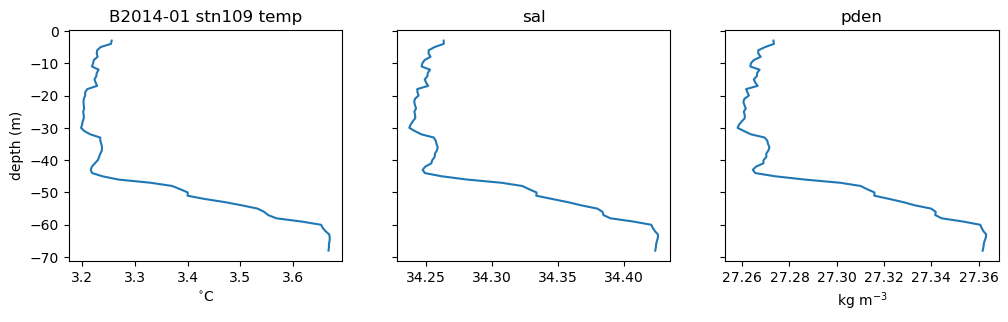

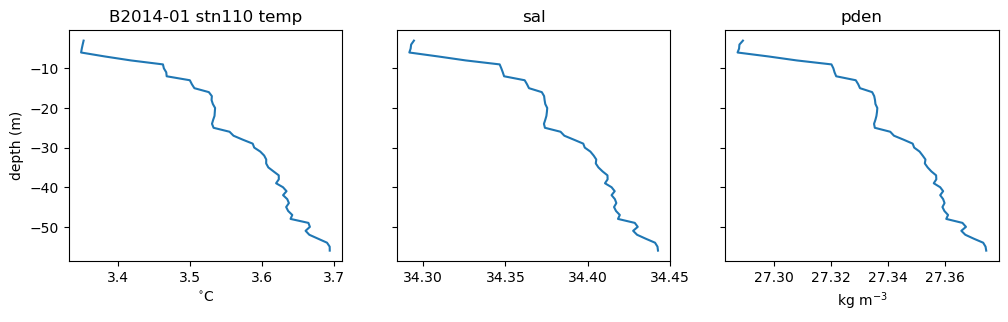

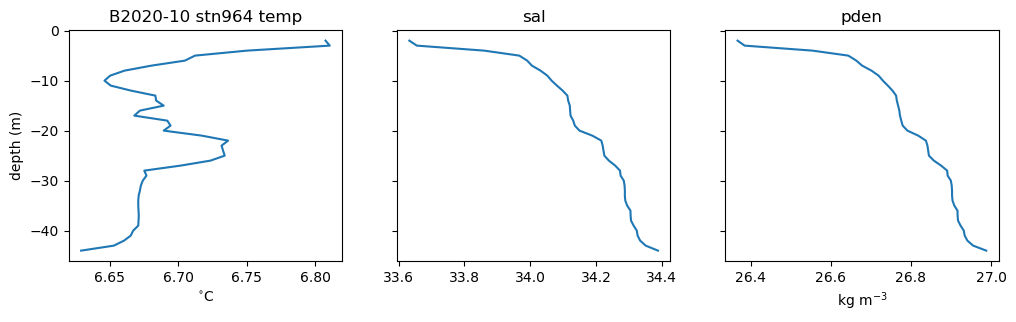

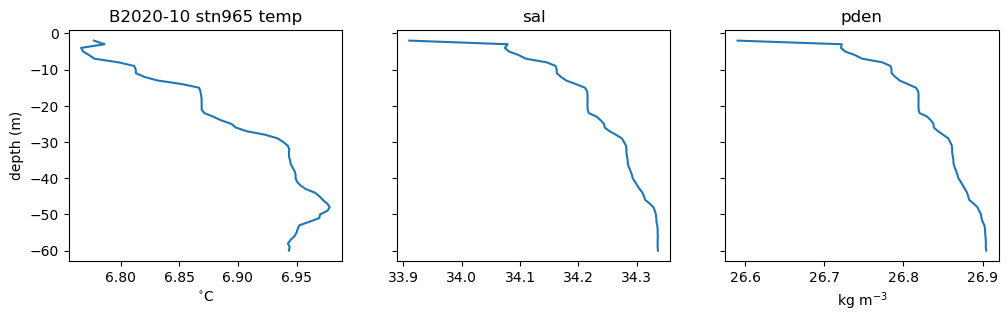

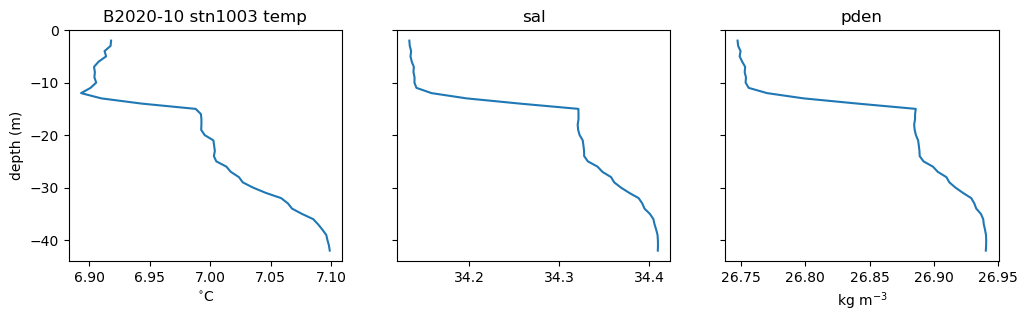

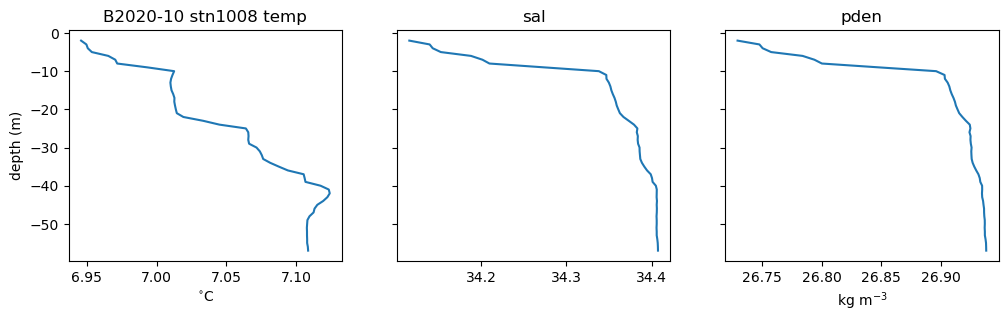

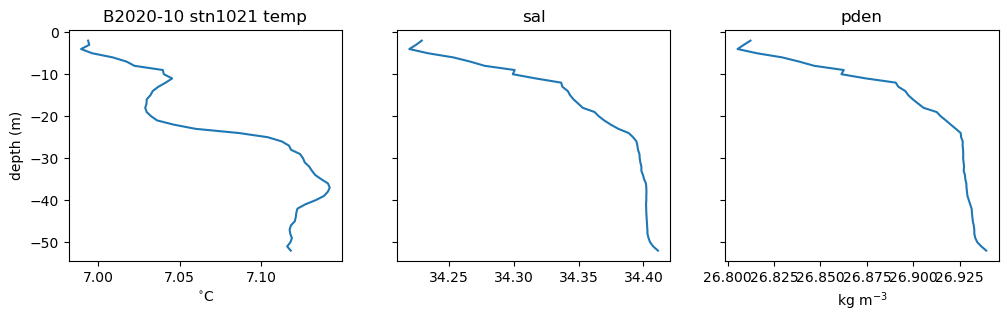

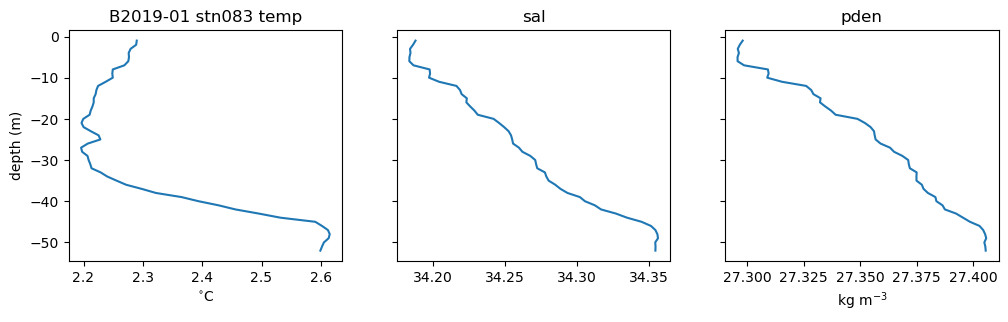

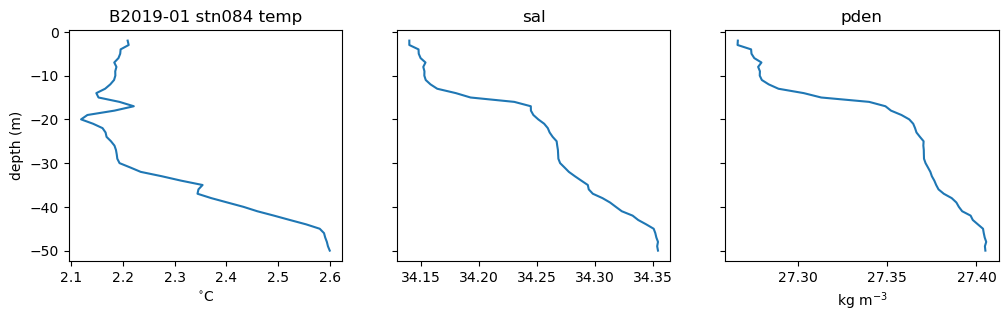

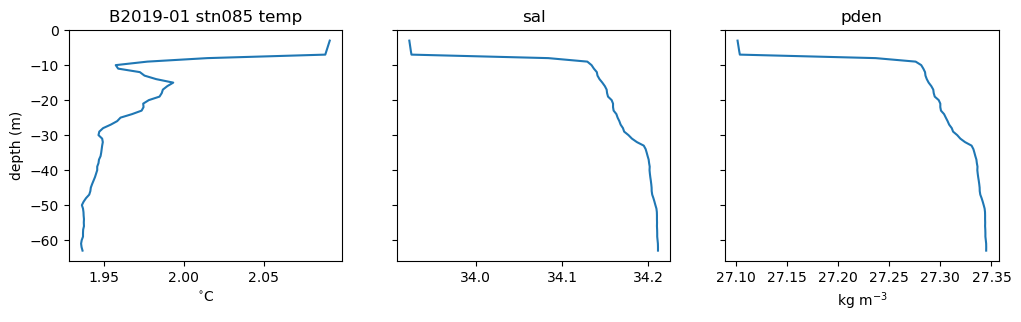

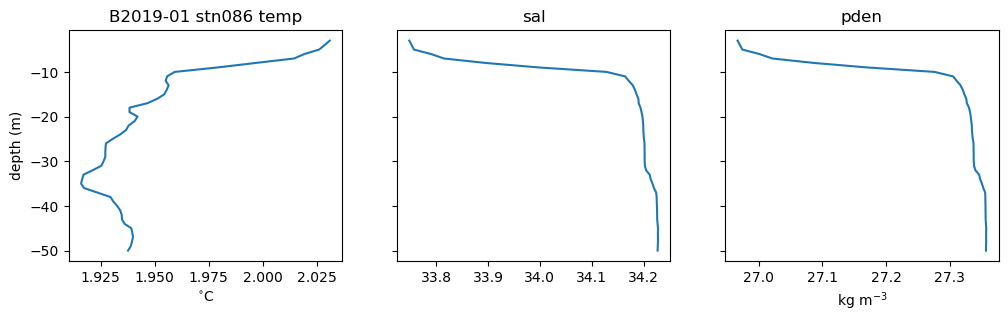

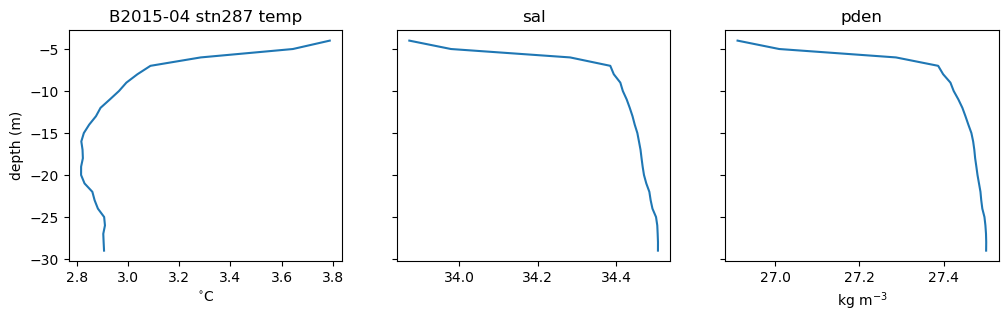

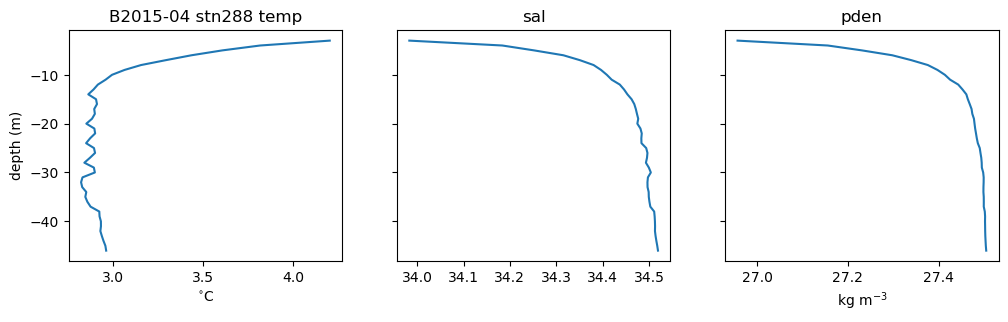

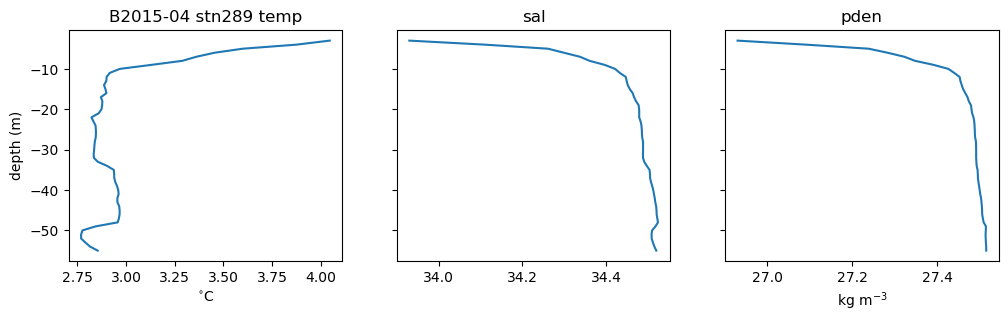

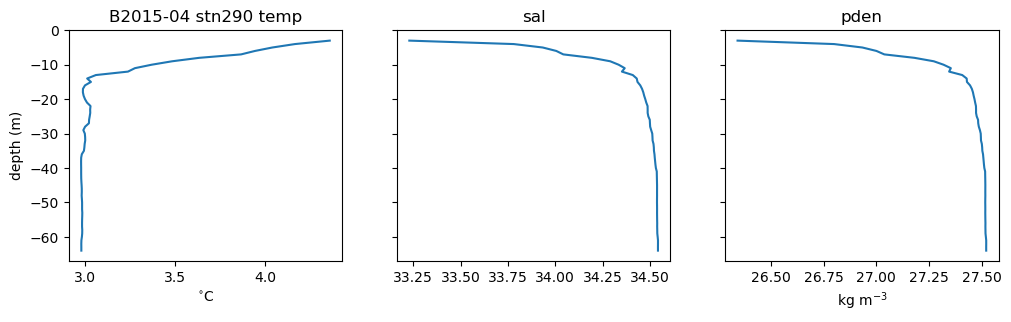

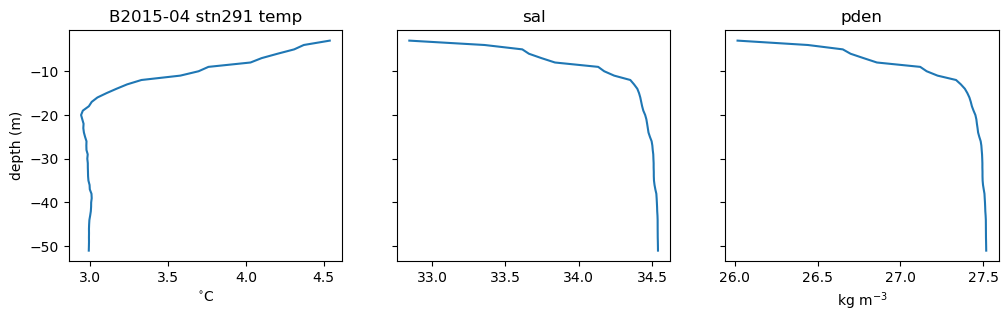

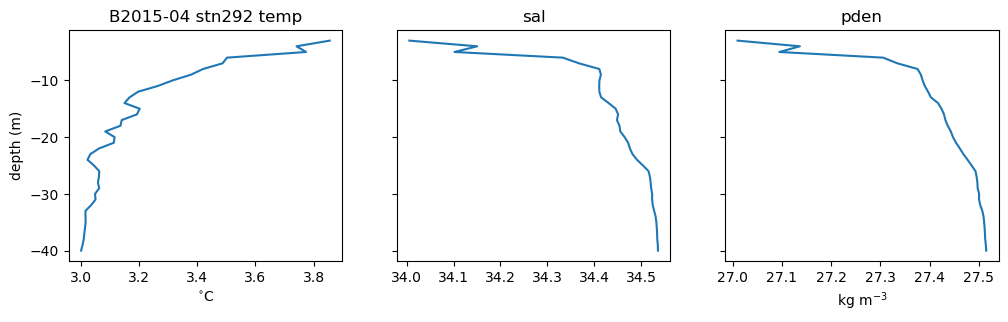

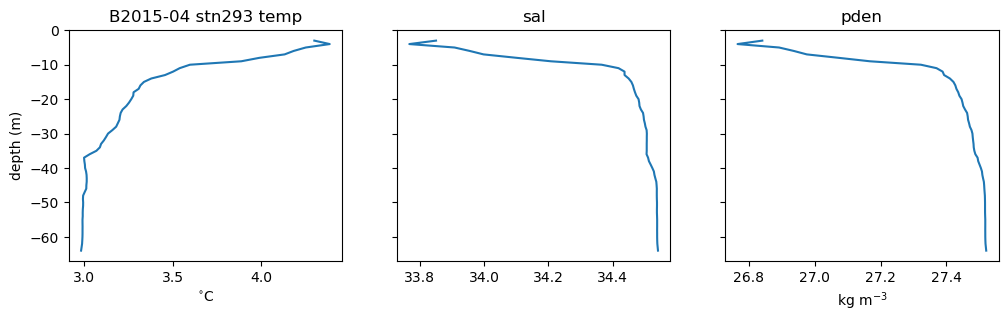

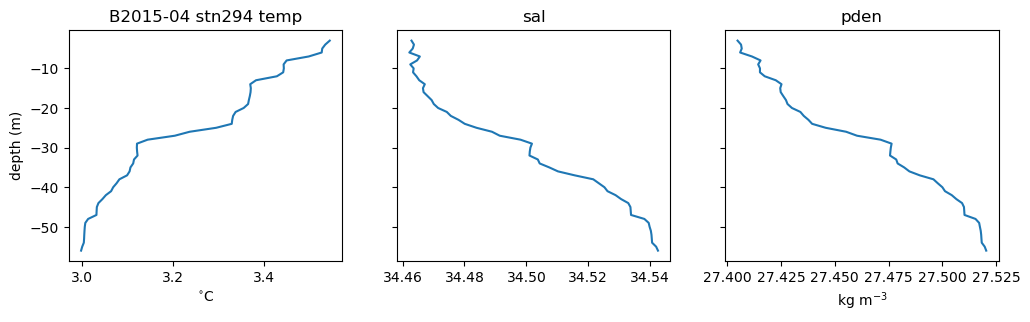

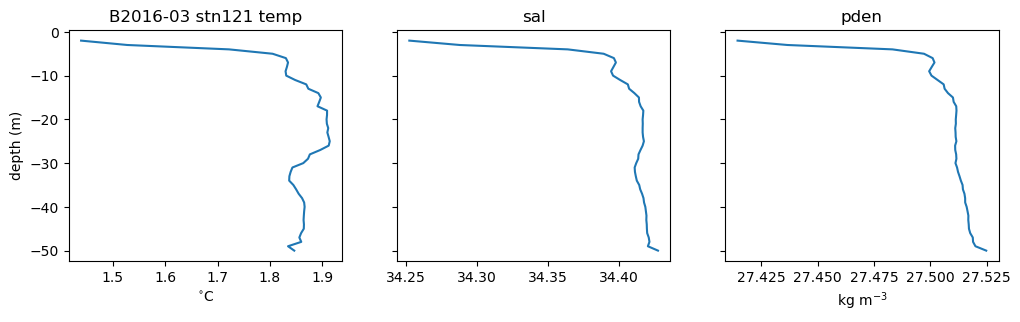

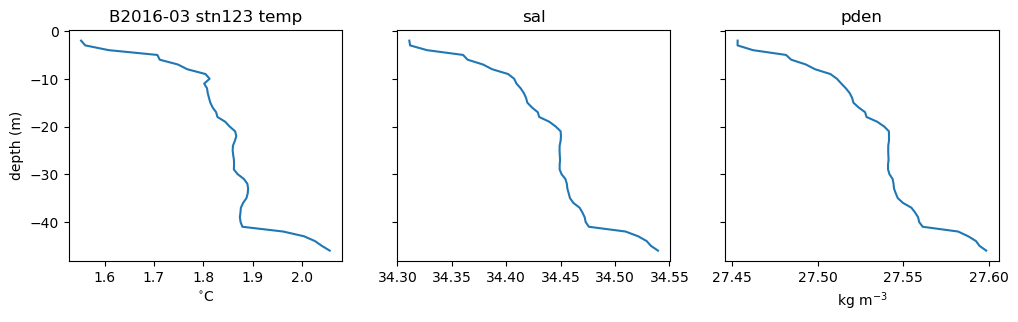

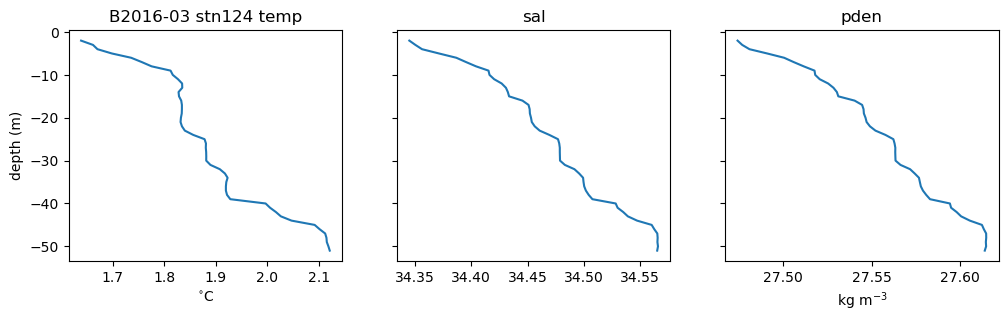

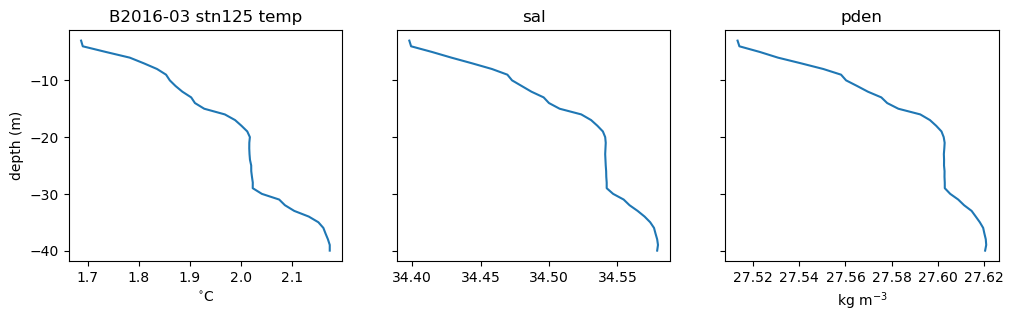

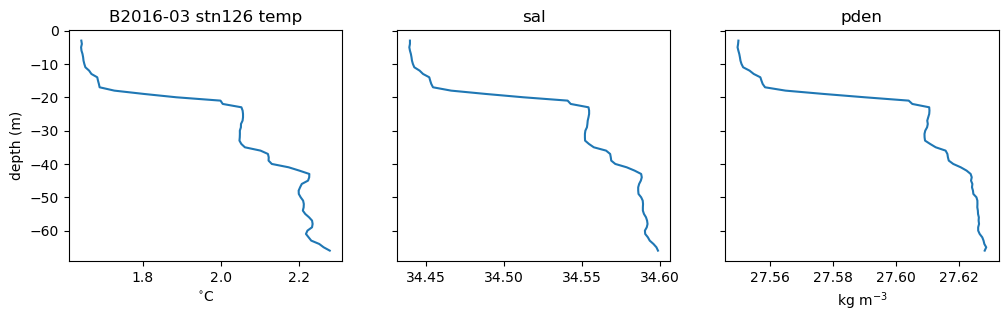

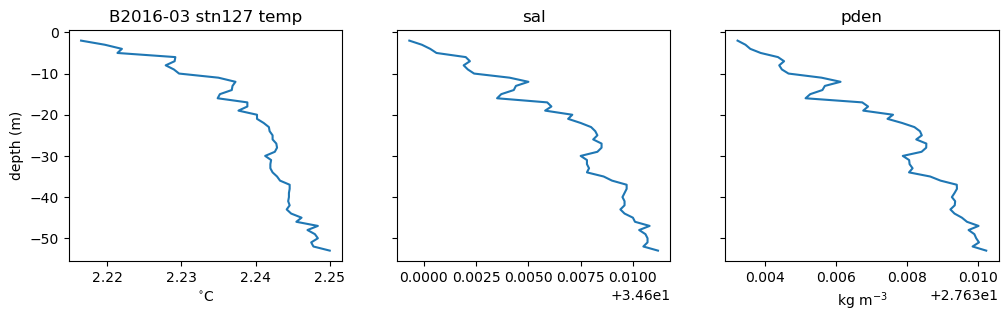

In [21]:
for filename in filenames:
    matdat = sio.loadmat(filedir+filename, squeeze_me=True)
    tt = matdat['tt']
    stations = tt.dtype.names

    for st in stations:
        df = get_dframe(filedir+filename, st)
        fig, (ax,ax2,ax3) = plt.subplots(1,3, figsize=(12,3), sharey=True)
        ax.plot(df.temp, -df.depth)
        ax2.plot(df.sal, -df.depth)
        ax3.plot(df.pden, -df.depth)
        plt.title(st)
        ax.set_title(filename[:-4] + ' ' + st + ' temp')
        ax2.set_title('sal')
        ax3.set_title('pden')
        ax.set_ylabel('depth (m)')
        ax.set_xlabel('$^{\circ}$C')
        ax2.set_xlabel(' ')
        ax3.set_xlabel('kg$~$m$^{-3}$')
        plt.show()